#CafChem tools for using ChemProp, a graph convolution neural , or GCNN-based message passing neural network (MPNN)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/CafChem/blob/main/notebooks/ChemProp_CafChem.ipynb)

## This notebook allows you to:
- Read in a CSV file with SMILES strings and featurize it.
- create the MPNN and train it.
- save and loads models.
- run inference on new samples.

## Requirements:
- This notebook will install chemprop
- It will pull the CafChem tools from Github.
- It will install all needed libraries.

## Set-up

### Install chemprop

In [ ]:
# Install chemprop from GitHub if running in Google Colab
import os

if os.getenv("COLAB_RELEASE_TAG"):
    try:
        import chemprop
    except ImportError:
        !git clone https://github.com/chemprop/chemprop.git
        %cd chemprop
        !pip install .
        %cd examples

Cloning into 'chemprop'...
remote: Enumerating objects: 25449, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 25449 (delta 108), reused 44 (delta 43), pack-reused 25245 (from 3)
Receiving objects: 100% (25449/25449), 873.27 MiB | 20.55 MiB/s, done.
Resolving deltas: 100% (18244/18244), done.
Updating files: 100% (337/337), done.
/content/chemprop
Processing /content/chemprop
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.2/824.2 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.8/187.8 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

### library set-up
- pull CafChem from Github
- import libraries

In [1]:
!git clone https://github.com/MauricioCafiero/CafChem.git

Cloning into 'CafChem'...
remote: Enumerating objects: 707, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 707 (delta 114), reused 54 (delta 54), pack-reused 571 (from 2)
Receiving objects: 100% (707/707), 41.88 MiB | 17.97 MiB/s, done.
Resolving deltas: 100% (402/402), done.


In [2]:
import numpy as np
import torch
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import CafChem.CafChemProp as ccp

## Load Data
- create your dataloaders by providing the names of the SMILES and target columns in the read_prep_data function.

In [3]:
input_path = "/content/6731-azo.csv"
df = pd.read_csv(input_path)
df.head()

,Name,SMILES,Lmax
0,1,Oc1cc(O)c2c(c1)O[C@@H]([C@@H](C2)OC(=O)c1cc(O)...,263.5
1,2,Brc1[nH]c2c(n1)c(Br)c(c(c2Br)Br)Br,264.0
2,3,Clc1ccc(c(c1)Cl)OCCn1cncc1,245.2
3,5,CC(=O)O[C@H]1[C@@H](O[C@@H]([C@H]1C(F)(F)F)COC...,242.5
4,6,COC(=O)Cc1ccc(cc1)OC[C@H]1OC1,245.9


In [4]:
all_data = ccp.chemprop_data()
all_data.read_prep_data(df, "SMILES", ["Lmax"], False)
scaler, train_loader, val_loader, test_loader = all_data.featurize_dataloaders()

Class chemprop_data initialized


Data read and split.
Data featurized.


## Constructs MPNN
- Choose your message passing type (bond or atom)
- Choose your aggregation type.
- (see code for options)

In [5]:
cp_model = ccp.chemprop_model()
cp_model.construct_model(scaler)

Class chemprop_model initialized


MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=300, bias=False)
    (W_h): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=372, out_features=300, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=300, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): MSE(task_weights=[[1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
  (metrics): ModuleList(
    (0): MAE(task_weights=[[1.0]])
    (1): MSE(task_weight

# Start training
- train and evaluate test set results

In [6]:
trainer = cp_model.train_model(train_loader, val_loader, epochs = 10, devices = 2)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
INFO:lightning.fabric.utilities.distributed:Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
INFO: Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
INFO:lightning.fabric.utilities.distributed:Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
INFO: ----------------------------------------------------------------------------------------------------
distributed_backend=gloo
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

INFO:lightning.py

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [7]:
results = cp_model.test_model(test_loader)

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
INFO:lightning.fabric.utilities.distributed:Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
INFO:lightning.fabric.ut

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    20.630252838134766     │
└───────────────────────────┴───────────────────────────┘

## Evaluation
- get predictions for the test set.
- get expanded versions of all 3 datasets
- Calculate R2 and plot test dataset.

In [8]:
full_preds = cp_model.get_test_preds(test_loader)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/saving.py:363: Skipping 'metrics' parameter because it is not possible to safely dump to YAML.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [9]:
full_train, full_val, full_test = all_data.get_full_dsets()

In [10]:
for exp, preds in zip(full_test, full_preds):
  print(f"exp: {exp:.2f}, pred: {preds:.2f}")

exp: 319.60, pred: 314.94
exp: 370.50, pred: 350.52
exp: 337.20, pred: 347.44
exp: 439.00, pred: 391.25
exp: 393.00, pred: 386.71
exp: 352.30, pred: 345.30
exp: 346.60, pred: 367.73
exp: 287.50, pred: 302.92
exp: 301.40, pred: 310.45
exp: 308.10, pred: 310.91
exp: 292.70, pred: 277.47
exp: 285.40, pred: 295.64
exp: 455.70, pred: 405.82
exp: 357.10, pred: 339.74
exp: 299.10, pred: 300.63
exp: 448.00, pred: 419.84
exp: 325.70, pred: 344.11
exp: 325.50, pred: 330.65
exp: 438.40, pred: 417.52
exp: 393.20, pred: 354.56
exp: 347.20, pred: 355.52
exp: 356.10, pred: 344.91
exp: 398.00, pred: 404.56
exp: 289.40, pred: 303.04
exp: 300.40, pred: 291.94
exp: 306.10, pred: 302.81
exp: 301.00, pred: 301.51
exp: 246.30, pred: 272.32
exp: 334.90, pred: 334.14
exp: 320.60, pred: 287.11
exp: 407.20, pred: 426.47
exp: 308.70, pred: 325.48
exp: 351.20, pred: 338.07
exp: 297.90, pred: 304.53
exp: 442.60, pred: 468.56
exp: 283.30, pred: 298.96
exp: 361.10, pred: 332.08
exp: 258.30, pred: 303.29
exp: 276.00,

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Test R2 = 0.84


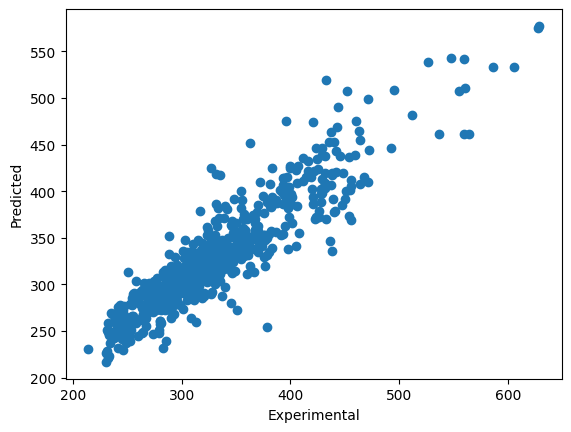

In [11]:
test_r2 = cp_model.r2_scores(full_test, test_loader)

## Inference
- Save and load models
- run inference

In [12]:
cp_model.save_model("/content/azo_model_84R2.pt")

Model saved to /content/azo_model_84R2.pt


In [13]:
new_cp = ccp.chemprop_model()
mpnn = new_cp.load_model("/content/azo_model_84R2.pt")

Class chemprop_model initialized


In [14]:
test_path ="/content/new-azo.csv"
smiles_column = "SMILES"
df_test = pd.read_csv(test_path)
df_test.head()

,Name,SMILES,Lmax
0,Ntz,CNC1=CC=C(/N=N/C2=NC=C([N+]([O-])=O)S2)C3=CC=C...,601
1,Nbztz,CNC1=CC=C(/N=N/C2=NC3=C(C=C([N+]([O-])=O)C=C3)...,588
2,diNO2,CNC1=CC=C(/N=N/C2=C([N+]([O-])=O)C=C([N+]([O-]...,578
3,iso-CN,CNC1=CC=C(/N=N/C2=C(C#N)C=C(C#N)C=C2)C3=CC=CC=C31,548
4,p-NO2,CNC1=CC=C(/N=N/C2=CC=C([N+]([O-])=O)C=C2)C3=CC...,525


In [15]:
new_data = all_data.make_new_dataloader(df_test, smiles_column)

In [16]:
new_preds = new_cp.get_test_preds(new_data)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/saving.py:363: Skipping 'metrics' parameter because it is not possible to safely dump to YAML.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [17]:
truths = df_test["Lmax"].values

In [18]:
mae = 0.0
for exp, pred in zip(truths, new_preds):
  delta = abs(exp - pred)
  mae += delta
  print(f"exp: {exp:10.2f}, pred: {pred:10.2f}, delta: {delta:10.2f}")
print("===========================")
print(f"MAE: {mae/len(truths):10.2f}")

exp:     601.00, pred:     490.29, delta:     110.71
exp:     588.00, pred:     458.83, delta:     129.17
exp:     578.00, pred:     453.80, delta:     124.20
exp:     548.00, pred:     453.95, delta:      94.05
exp:     525.00, pred:     432.03, delta:      92.97
exp:     547.00, pred:     426.53, delta:     120.47
exp:     525.00, pred:     402.38, delta:     122.62
exp:     503.00, pred:     405.46, delta:      97.54
exp:     498.00, pred:     418.63, delta:      79.37
exp:     481.00, pred:     426.71, delta:      54.29
exp:     470.00, pred:     407.30, delta:      62.70
exp:     465.00, pred:     398.77, delta:      66.23
exp:     452.00, pred:     402.37, delta:      49.63
exp:     448.00, pred:     410.81, delta:      37.19
exp:     445.00, pred:     418.08, delta:      26.92
exp:     433.00, pred:     386.22, delta:      46.78
exp:     384.00, pred:     389.08, delta:       5.08
exp:     379.00, pred:     375.45, delta:       3.55
MAE:      73.53


In [19]:
from sklearn.metrics import r2_score

r2 = r2_score(truths, new_preds)
print(r2)

-0.7407290622995075


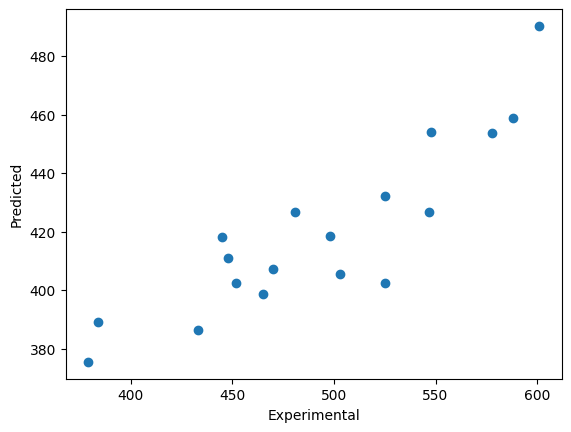

In [20]:
import matplotlib.pyplot as plt

plt.scatter(truths, new_preds)
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.show()